## Wine Quality Using a DNN
Tutorial Located Here: https://www.tensorflow.org/tutorials/keras/regression#full_model

## Get the Data

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.1


In [15]:
raw_dataset = pd.read_csv('data/winequality-red.csv')

In [16]:
dataset = raw_dataset.copy()
dataset.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


## Split the Data

In [17]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [18]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('quality')
test_labels = test_features.pop('quality')

## Normalization

In [19]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
fixed acidity,8.310164,1.744190
volatile acidity,0.525571,0.176645
citric acid,0.271618,0.196822
residual sugar,2.516341,1.300985
chlorides,0.087347,0.045666
free sulfur dioxide,15.868647,10.438880
total sulfur dioxide,46.488663,32.952841
density,0.996739,0.001888
pH,3.312588,0.153923
sulphates,0.655012,0.160192


### The Normalization Layer

In [20]:
normalizer = preprocessing.Normalization()

In [21]:
normalizer.adapt(np.array(train_features))

In [22]:
print(normalizer.mean.numpy())

[ 8.31   0.526  0.272  2.516  0.087 15.869 46.489  0.997  3.313  0.655
 10.436]


In [23]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[10.8   0.47  0.43  2.1   0.17 27.   66.    1.    3.17  0.76 10.8 ]]

Normalized: [[ 1.43 -0.31  0.81 -0.32  1.83  1.07  0.59  0.77 -0.93  0.66  0.34]]


## Linear Regression

In [25]:
alcohol = np.array(train_features['alcohol'])

alcohol_normalizer = preprocessing.Normalization(input_shape=[1,])
alcohol_normalizer.adapt(alcohol)

In [26]:
alcohol_model = tf.keras.Sequential([
    alcohol_normalizer,
    layers.Dense(units=1)
])

alcohol_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Run the model on the first 10 values.

In [27]:
alcohol_model.predict(alcohol[:10])

array([[-0.361],
       [ 0.831],
       [-1.256],
       [ 0.433],
       [ 0.036],
       [ 1.328],
       [ 0.533],
       [-0.461],
       [ 0.831],
       [ 1.129]], dtype=float32)

In [28]:
alcohol_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [41]:
%%time
history = alcohol_model.fit(
    train_features['alcohol'], train_labels,
    epochs=20,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Wall time: 1.27 s


In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
15,0.538457,0.574243,15
16,0.533737,0.574049,16
17,0.538611,0.580413,17
18,0.543249,0.583330,18
19,0.540954,0.578993,19


In [43]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('Error [quality]')
  plt.legend()
  plt.grid(True)

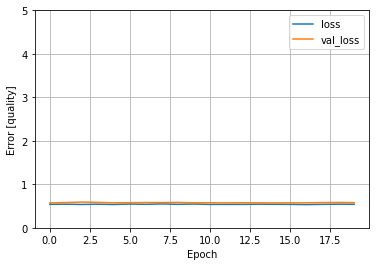

In [44]:
plot_loss(history)

In [46]:
test_results = {}

test_results['alcohol_model'] = alcohol_model.evaluate(
    test_features['alcohol'],
    test_labels, verbose=0)

In [54]:
x = tf.linspace(0.0, 20, 21)
y = alcohol_model.predict(x)

In [55]:
def plot_alcohol(x, y):
  plt.scatter(train_features['alcohol'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('alcohol')
  plt.ylabel('quality')
  plt.legend()

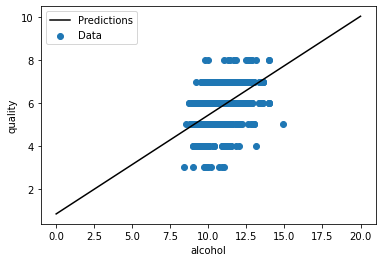

In [56]:
plot_alcohol(x,y)

## DNN Regression

In [57]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [58]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 11)                23        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [59]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 6.91 s


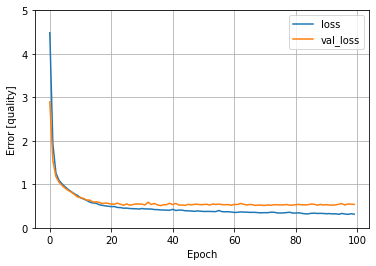

In [60]:
plot_loss(history)

In [61]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [63]:
pd.DataFrame(test_results, index=['Mean absolute error [quality]']).T

,Mean absolute error [quality]
alcohol_model,0.541375
dnn_model,0.513726


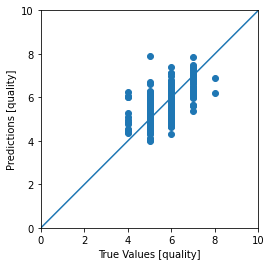

In [65]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [quality]')
plt.ylabel('Predictions [quality]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

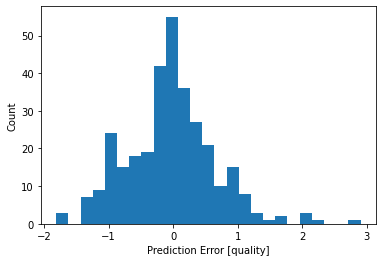

In [67]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [quality]')
_ = plt.ylabel('Count')

In [71]:
error = round(error)
count = 0
count_non_0 = 0

for i in error:
    if i != 0:
        count_non_0 += 1
    count += 1
    
print(1-count_non_0/count)

0.5875
